Ячейка для импортов всего что можно и нельзя:

In [2]:
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import re
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torchmetrics import F1
from torchmetrics.functional import f1, recall

парочка вещей, которые пригодятся нам в процессе препроцессинга:

In [3]:
stoplist = list('qwertyuiopasdfghjklzxcvbnm12345678990!@#$%^&*()_+:;,./—')

In [4]:
def preprocess(text):
    tokens = re.split('\)| |\!|\?|\.|\,|\(|\...|d|~|\"|\\n', text.lower())
    tokens = [token.strip(punctuation+'d'+'…'+'“'+'”') for token in tokens if not token.startswith('@') and token!='' and token[0] not in stoplist]
    return [token for token in tokens if len(token)>1]

прочитаем файлы и положим в датафрейм:

In [5]:
files=['positive.csv', 'negative.csv']
#names='id,tdate,tname,ttext,ttype,trep,trtw,tfav,tstcount,tfol,tfrien,listcount'

In [6]:
data = pd.concat([pd.read_csv(file, encoding='utf-8', sep=';', usecols=[3,4], names=['text', 'type']) for file in files])

обработаем колонки: ярлыки у нас не должны иметь класс -1, а тексты стоит из списков превратить снова в строки:

In [7]:
data.type = data.type.map({1:1,-1:0})
data.text = data.text.map(preprocess).apply(lambda x:' '.join(x))

In [36]:
data.head()

,text,type
0,хоть школота но поверь нас то же самое обществ...,1
1,да все-таки он немного похож на него но мой ма...,1
2,ну ты идиотка испугалась за тебя,1
3,кто то углу сидит погибает от голода мы ещё по...,1
4,вот что значит страшилка но блин посмотрев все...,1


так-то лучше. Теперь можно данные и поделить на датасеты, и на всякий случай индексы переставить.

In [9]:
train_data, val_data = train_test_split(data, test_size=0.2)
train_data.reset_index(drop=True, inplace=True)
val_data.reset_index(drop=True, inplace=True)

Можем начинать собирать словарь уникальных слов!

(интеллигентно передирая код из тетрадки с семинара)

In [10]:
vocab = Counter()
for tweet in data['text']:
    vocab.update(preprocess(tweet))
print('всего уникальных слов:', len(vocab))

всего уникальных слов: 179013


In [11]:
vocab

Counter({'хоть': 2157,
         'школота': 11,
         'но': 16220,
         'поверь': 71,
         'нас': 4242,
         'то': 12056,
         'же': 9801,
         'самое': 1049,
         'общество': 70,
         'профилирующий': 1,
         'предмет': 80,
         'типа': 516,
         'да': 9664,
         'все-таки': 341,
         'он': 7005,
         'немного': 920,
         'похож': 158,
         'на': 38115,
         'него': 1640,
         'мой': 3294,
         'мальчик': 231,
         'все': 17064,
         'равно': 1445,
         'лучше': 2201,
         'ну': 13083,
         'ты': 15441,
         'идиотка': 37,
         'испугалась': 60,
         'за': 10766,
         'тебя': 7489,
         'кто': 4067,
         'углу': 42,
         'сидит': 269,
         'погибает': 3,
         'от': 6010,
         'голода': 30,
         'мы': 6559,
         'ещё': 2713,
         'порции': 12,
         'взяли': 126,
         'хотя': 1761,
         'уже': 10988,
         'так': 18925,
        

стильно. Давайте по частоте фильтровать.

In [12]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 5:
        filtered_vocab.add(word)
print('уникальных токенов, встретившихся больше 5 раз:', len(filtered_vocab))

уникальных токенов, встретившихся больше 5 раз: 26860


делаем словарики, идентификационный и дешифровочный:

In [13]:
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [15]:
id2word = {i:word for word, i in word2id.items()}

и намекнем торчу, что у нас по графическому ресурсу:

In [155]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

строим класс датасета!
без особой выдумки переставляем, что нужно, в коде с семинара

In [16]:
class TweetsDataset(Dataset):

    def __init__(self, dataset, word2id, DEVICE):
        self.dataset = dataset['text'].values
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.target = dataset['type'].values
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        words = preprocess(self.dataset[index])
        ids = torch.LongTensor([self.word2id[word] for word in words if word in self.word2id])
        y = [self.target[index]]
        return ids, y

    def collate_fn(self, batch):
        ids, y = list(zip(*batch))
        padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
        y = torch.Tensor(y).to(self.device)
        return padded_ids, y

In [17]:
train_dataset = TweetsDataset(train_data, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

In [18]:
val_dataset = TweetsDataset(val_data, word2id, DEVICE)
val_sampler = RandomSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

ну что, оно живо?

In [19]:
id2word[1864]

'бабуля'

прекрасно! А того ли оно размера?

In [20]:
batch = next(iter(train_iterator))
#[id2word[int(i)] for i in batch[0][0]]
batch[0].shape

torch.Size([1024, 22])

потрясающе.

# Модель с одним входом

делаем нашу большую и загадочную сверточную сетку! 

In [22]:
class CNN(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=256, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=3, padding='same')
        self.concat_bigrams = nn.Conv1d(in_channels=356, out_channels=256, kernel_size=2, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=256, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()

    def forward(self, text):
        #batch_size x seq_len
        embedded = self.embedding(text)
        #batch_size x seq_len x embedding_dim
        embedded = embedded.transpose(1,2)
        #batch_size x embedding_dim x seq_len
        feature_map_bigrams = self.dropout(self.pooling(self.relu(self.bigrams(embedded))))
        #batch_size x filter_count2 x seq_len* 
        feature_map_trigrams = self.dropout(self.pooling(self.relu(self.trigrams(embedded))))

        concat = torch.cat((feature_map_bigrams, feature_map_trigrams), 1)
        feature_map_concat = self.relu(self.concat_bigrams(concat))
        pooling = feature_map_concat.max(2)[0]
        logits = self.hidden(pooling)
        logits = self.out(logits)
        
        return logits


пора проверить, как она себя чувствует. Сделаем какой-нибудь батч и запустимся на нем.

In [23]:
batch, y = next(iter(train_iterator))

In [24]:
print(batch)

tensor([[25530, 10117,     0,  ...,     0,     0,     0],
        [23055, 21607,  8345,  ...,     0,     0,     0],
        [ 7697, 17198,  8826,  ...,     0,     0,     0],
        ...,
        [19744,  3654,     0,  ...,     0,     0,     0],
        [ 2187, 16776,  9479,  ...,     0,     0,     0],
        [18357, 26076, 11706,  ...,     0,     0,     0]], device='cuda:0')


In [25]:
batch, y = batch.to(device='cpu'), y.to(device='cpu')
model = CNN(len(id2word), 1024)
output = model(batch)
print(output)

/home/yana/.local/lib/python3.6/site-packages/torch/nn/modules/conv.py:298: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:647.)
  self.padding, self.dilation, self.groups)


tensor([[0.6414],
        [0.6689],
        [0.6753],
        ...,
        [0.6437],
        [0.6658],
        [0.6356]], grad_fn=<SigmoidBackward0>)


она что-то предсказывает! Уже маленькая победа. С какой же ошибкой?

In [26]:
loss = nn.BCELoss()
loss(output, y)

tensor(0.7500, grad_fn=<BinaryCrossEntropyBackward0>)

In [27]:
f1(output, y.long())

tensor(0.6753)

ну...для нетренированной пойдет. Теперь пора строить функцию для тренировки и оценки - и сразу проспойлерим все веселье, дав ей возможность менять поведение в зависимости от того, два входа или один

In [134]:
def train(model, iterator1, optimizer, criterion, flag):
    epoch_loss = 0 # для подсчета среднего лосса на всех батчах

    model.train()  # ставим модель в обучение, явно указываем, что сейчас надо будет хранить градиенты у всех весов
    if flag ==1: 
        for i, (texts, ys) in enumerate(iterator1): #итерируемся по батчам
            optimizer.zero_grad()  #обнуляем градиенты
            preds = model(texts)  #прогоняем данные через модель
            loss = criterion(preds, ys) #считаем значение функции потерь  
            loss.backward() #считаем градиенты  
            optimizer.step() #обновляем веса 
            epoch_loss += loss.item() #сохраняем значение функции потерь
            if not (i + 1) % int(len(iterator1)/5):
                print(f'Train loss: {epoch_loss/i}')
        return  epoch_loss / len(iterator1)
    elif flag == 2:
        for i, (words, texts, ys) in enumerate(iterator1): #итерируемся по батчам
            optimizer.zero_grad()  #обнуляем градиенты
            preds = model(words, texts)  #прогоняем данные через модель
            loss = criterion(preds, ys) #считаем значение функции потерь  
            loss.backward() #считаем градиенты  
            optimizer.step() #обновляем веса 
            epoch_loss += loss.item() #сохраняем значение функции потерь
            if not (i + 1) % int(len(iterator1)/5):
                print(f'Train loss: {epoch_loss/i}')
        return  epoch_loss / len(iterator1)

In [220]:
def evaluate(model, iterator1, criterion, flag):
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        if flag == 1: 
            for i, (texts, ys) in enumerate(iterator1):   
                preds = model(texts)  # делаем предсказания на тесте
                loss = criterion(preds, ys)   # считаем значения функции ошибки для статистики  
                epoch_loss += loss.item()
                batch_metric = f1(preds.round().long(), ys.long(), ignore_index=0)
                epoch_metric += batch_metric

                if not (i + 1) % int(len(iterator1)/5):
                    print(f'Val loss: {epoch_loss/i}, Val f1: {epoch_metric/i}')
        
            return epoch_metric / len(iterator1), epoch_loss / len(iterator1)

        elif flag == 2:
            for i, (words, texts, ys) in enumerate(iterator1):   
                preds = model(words, texts)  # делаем предсказания на тесте
                loss = criterion(preds, ys)   # считаем значения функции ошибки для статистики  
                epoch_loss += loss.item()
                batch_metric = f1(preds.round().long(), ys.long(), ignore_index=0)
                epoch_metric += batch_metric

                if not (i + 1) % int(len(iterator1)/5):
                    print(f'Val loss: {epoch_loss/i}, Val f1: {epoch_metric/i}')
        
            return epoch_metric / len(iterator1), epoch_loss / len(iterator1)            

В качестве размера вектора дадим ей 1024 и попробуем запуститься со случайным значением скорости обучения:

In [30]:
model = CNN(len(word2id), 1024)
optimizer = optim.Adam(model.parameters(), lr=0.0015)
criterion = nn.BCELoss()  

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [31]:
%%time
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(10):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model=model, iterator1 = train_iterator, optimizer=optimizer, criterion=criterion, flag=1)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator, criterion, flag=1)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion, flag=1)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)


starting Epoch 0
Training...
Train loss: 0.7790092107127694
Train loss: 0.6962753275166387
Train loss: 0.6601548492908478
Train loss: 0.639348969185095
Train loss: 0.6234144530762201

Evaluating on train...
Val loss: 0.5157954175682629, Val f1: 0.7917081713676453
Val loss: 0.510820083860038, Val f1: 0.7762958407402039
Val loss: 0.509574462301456, Val f1: 0.7715710401535034
Val loss: 0.5080444392540472, Val f1: 0.7700495719909668
Val loss: 0.5077814877718344, Val f1: 0.7688723206520081

Evaluating on test...
Val loss: 0.613083653151989, Val f1: 0.8248929381370544
Val loss: 0.5797742149409126, Val f1: 0.7740707993507385
Val loss: 0.5701567026285025, Val f1: 0.7542278170585632
Val loss: 0.5621513656207493, Val f1: 0.7485235929489136
Val loss: 0.5586000098423525, Val f1: 0.7442552447319031

starting Epoch 1
Training...
Train loss: 0.5215489101760528
Train loss: 0.5135797253553418
Train loss: 0.5122662785534675
Train loss: 0.511439625951026
Train loss: 0.5111072215883211

Evaluating on tra

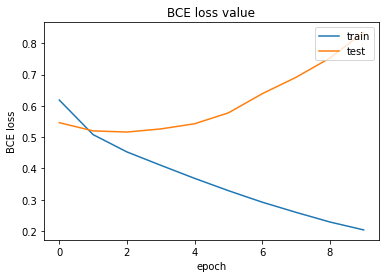

In [32]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

это...не очень.

И как же это мы так здорово ушли в оверфит? Давайте исправляться - попробуем понизить скорость обучения:

In [33]:
model = CNN(len(word2id), 1024)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss()  

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [34]:
%%time
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(10):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model=model, iterator1 = train_iterator, iterator2 = train_iterator, optimizer=optimizer, criterion=criterion, flag=1)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator, train_iterator, criterion, flag=1)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, val_iterator, criterion, flag=1)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)


starting Epoch 0
Training...
Train loss: 0.7028508291525
Train loss: 0.6685511815375176
Train loss: 0.6477931938492335
Train loss: 0.6340190390888736
Train loss: 0.6237572222605519

Evaluating on train...
Val loss: 0.5608081133926616, Val f1: 0.7738843560218811
Val loss: 0.5505446377007858, Val f1: 0.7638444304466248
Val loss: 0.5483646742426432, Val f1: 0.7594330906867981
Val loss: 0.5471908437262336, Val f1: 0.7578586339950562
Val loss: 0.5465522730487516, Val f1: 0.7569061517715454

Evaluating on test...
Val loss: 0.6351393833756447, Val f1: 0.8213350772857666
Val loss: 0.6020425873644212, Val f1: 0.7717985510826111
Val loss: 0.5914237705560831, Val f1: 0.7566863894462585
Val loss: 0.5858985917908804, Val f1: 0.7492754459381104
Val loss: 0.581317277117209, Val f1: 0.7466506361961365

starting Epoch 1
Training...
Train loss: 0.5644736114670249
Train loss: 0.5561401921769847
Train loss: 0.5512656219876729
Train loss: 0.5479711748713212
Train loss: 0.5446195622970318

Evaluating on tr

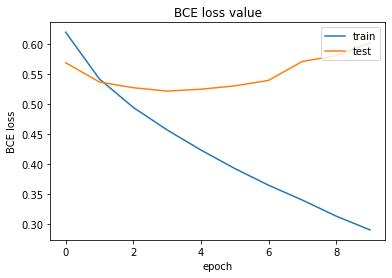

In [35]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

что ж, совет постановляет, что это жесть. А мы ведь даже дропауты использовали!

Ладно, обрежем ей число эпох. Судя по графику, понесло ее эпохе на...третьей?

In [40]:
model = CNN(len(word2id), 1024)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss()  

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [41]:
%%time
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(4):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model=model, iterator1 = train_iterator, iterator2 = train_iterator, optimizer=optimizer, criterion=criterion, flag=1)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator, train_iterator, criterion, flag=1)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, val_iterator, criterion, flag=1)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)


starting Epoch 0
Training...
Train loss: 0.7058818445486181
Train loss: 0.6696239804876023
Train loss: 0.6481763038497704
Train loss: 0.6339476160008273
Train loss: 0.6234715498726944

Evaluating on train...
Val loss: 0.5631845838883344, Val f1: 0.7328543066978455
Val loss: 0.5522574911946836, Val f1: 0.7230696678161621
Val loss: 0.5477911560581281, Val f1: 0.7196733355522156
Val loss: 0.5467129259658374, Val f1: 0.7182844877243042
Val loss: 0.5459005154412369, Val f1: 0.7176396250724792

Evaluating on test...
Val loss: 0.6552571803331375, Val f1: 0.7630871534347534
Val loss: 0.6119932672556709, Val f1: 0.7189170718193054
Val loss: 0.5993627561972692, Val f1: 0.7048455476760864
Val loss: 0.5906229938779558, Val f1: 0.7005565762519836
Val loss: 0.5863927846605127, Val f1: 0.696143627166748

starting Epoch 1
Training...
Train loss: 0.5660297327181872
Train loss: 0.553634782632192
Train loss: 0.5486363338736387
Train loss: 0.5455656218871796
Train loss: 0.5433450098010315

Evaluating on 

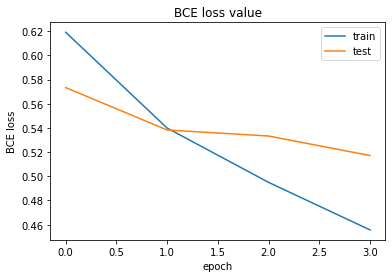

In [42]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Вот и умница, пусть так и остается. Это очевидно лучше, чем результат, который мы получили на выходе в прошлый раз.

Ладно, и где же мы косячим?

In [48]:
def predict(model, iterator):
    model.eval()
    fp = []
    fn = []
    tp = [] 
    tn = []
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds = model(texts)  # делаем предсказания на тесте 
            for pred, gold, text in zip(preds, ys, texts):
                text = ' '.join([id2word[int(word)] for word in text if word !=0])
                if round(pred.item()) > gold:
                    fp.append(text)
                elif round(pred.item()) < gold:
                    fn.append(text)
                elif round(pred.item()) == gold == 1:
                    tp.append(text)
                elif round(pred.item()) == gold == 0:
                    tn.append(text)
    return fp, fn, tp, tn

In [49]:
fp, fn, tp, tn = predict(model, val_iterator)

In [50]:
print('что правильно предсказываем:', tp[:100])

что правильно предсказываем: ['более чем правда может быть они все-таки днем где-то спят', 'смех грех', 'ты сама то как думаешь', 'шоб сушить аж все би щоб ті', 'боже братуха ты ретвитишь мои посты ума сойти', 'гы блоге удалилась запись что завтра они открывают код ядра будем поглядеть', 'да ну нормальном мы тут просто второй день пока что не сказать чтобы кухня была какая-то порции только огромные', 'интересно что она там увидела такого страшного', 'теперь карму не спасибо за то что даже из смог провести меня руки вверх', 'нет учебные планы каждого класса для предмета для каждого урока на весь год', 'конечно нет удивилась просто', 'завтра увижу лизу лешу юхуууу', 'твит луи для', 'меня такое за окном уже нуль нуль', 'так как пополняются читатели это большим количеством так что даже не успеваю считать но вы конечно можете все', 'дома не забыть бы что сегодня понедельник кое кто меня радует', 'знаю что ты скоро ну жива стою на ногах моя честь не досталась так что норм хдд', 'как ты угада

ну что тут. Явно эмоциональные слова, пожелания счастья-любви-хорошего-спокойной ночи - все это мы выявляем на ура.

In [51]:
print('что правильно предсказываем как плохое:', tn[:100])

что правильно предсказываем как плохое: ['как быть если тот кого безумно любишь живет другой стране', 'не знаю что делать поэтому не могу решить эту проблему', 'ибо не выдержала сожрала пол шоколадки позор мне', 'во бля спалилась', 'одну сторону они издеваются', 'вот сегодня совсем разболелась почти не могу говорить надеюсь вы не болеете мои хорошие', 'блять он олень сука коньки не взял вот баран на своих буду', 'увы', 'да по-моему мы просто хотели но не нашли', 'никогда не думала что могу привыкнуть так человеку интернете на умер мой товарищ все таки таких друзей терять тяжело', 'аналогично не хочу шк настроения нет тебе тож завтра школку', 'утра просрал день святого патрика', 'жаль заберу ее только после праздников придется ей полежать на до января', 'главная новость дня волгоград', 'да щас сварю встану хд жаль ты далеко сварила бы мне чо', 'да так обычная ситуация привык уже', 'от усталости уже не хочется всей этой новогодней мишуры', 'посмотреть сейчас серию это ведь как открыть ка

ладно, "позор мне", "везде безысходность" и "жизнь боль" не оставляют особых сомнений.

In [52]:
print('ошибочно отрицательное:', fn[:100])

ошибочно отрицательное: ['лох нее была такая возможность поработать самым лучшим но она ее проебала ибо нехуй спать столько', 'аня старалась даже английский прогуляла', 'ответ на двух как всегда', 'очень норм но грустно что россии весь хоккей этом', 'нихуя ты только горе', 'камера', 'уже несу только прежде скажи мне зачем', 'не плохо даже есть где приготовить', 'мои дома все совы поэтому дарят подарок поздравляют не утра', 'давайте так влез простите', 'что тебя больше всего но она моя', 'действительно нужно забыть весь негатив тех кто ним был связан идти вперёд', 'не совсем своей но тогда еще там не работала', 'до меня не дошло что ты не спал вовсе', 'не видела всего дня уже так соскучилась как будто месяц не видела это любовь', 'полуфинал только финал чуть позже хотя думаю где полуфинал там финал это же наргиз закирова иначе быть не может', 'да пожалуйста ни кому не же', 'таком количестве даже если очень тяжело', 'иногда меня фотографируют', 'фууу лох тебя флешка на гигов меня на ну в

ладно, я ее понимаю. Бедная сетка. То ей про то, как пахнет кошка, то про то, что серега плохой дядя, то матерятся от восхищения...

In [53]:
print('ошибочно положительное:', fp[:100])

ошибочно положительное: ['думала что не идёт спасибо', 'красным маркером по белой рубашки можно как-то вывести пятно', 'не умею показывать своё отношение близким людям моя любовь выглядит так будто любой момент готова продать их рабство', 'вообще не думаю что кто то будет его нормально отмечать такой', 'плакала сегодня смотря пусть говорят', 'были тире опять но этот раз немного хуже', 'сегодня первый раз снег на улицу болела', 'какая получишь', 'блин дима что ты за человек ржу опять как дебил второй раз за утро уже', 'лучше сейчас потом могут быть', 'идиот знаю меня вообще тви очень долго уже не было но меня пздц какие тут проблемы так что надеюсь простите', 'прочитала скандал битва хуев ой', 'злюсь на тебя не за то что ты сделала за то что ты мне лучше бы правду сказала ага сказала правду таких же пиздюлей получила', 'что вами дети почему вы не играете сидите такие мы играем во взрослых', 'рядом со мной опять лампочки ахах', 'всем привет больной укол', 'ним уже пару месяцев такое не о

о, а кто не плакал, смотря пусть говорят. Но если серьезно, то никаких грубых случаев не видно - я бы тоже их как положительные большей частью разметила, а ведь я тут вроде не нейросеть.

# Модель с двумя входами

что ж, пришло время воскресить не очень древнее зло - снова лезем в тетрадку с семинара, потому что теперь нам нужен словарь символов.

In [54]:
vocab_c = Counter()
for c in train_data.text:
    vocab_c.update(''.join(preprocess(c)))
print('всего уникальных символов:', len(vocab_c))

всего уникальных символов: 258


In [55]:
vocab_c

Counter({'д': 299482,
         'о': 976452,
         'б': 181269,
         'р': 369457,
         'е': 787803,
         'у': 292061,
         'т': 631613,
         'н': 605868,
         'а': 832943,
         'з': 137525,
         'в': 298406,
         'к': 334697,
         'с': 440948,
         'ъ': 1791,
         'л': 381251,
         'г': 147496,
         'я': 175580,
         'ч': 164785,
         'и': 501010,
         'й': 106238,
         'м': 296182,
         'ю': 76618,
         'х': 111439,
         'э': 41422,
         'п': 264222,
         'ш': 81503,
         'ь': 203975,
         'ы': 144289,
         'ж': 100679,
         'ф': 26231,
         'щ': 29387,
         'ё': 15710,
         'ц': 28505,
         '_': 1638,
         '-': 18118,
         ':': 2179,
         'í': 2,
         'a': 774,
         'і': 2350,
         'қ': 287,
         'ү': 1933,
         'ғ': 126,
         'ң': 126,
         'ө': 1354,
         '№': 50,
         '3': 1369,
         '1': 260,
         '0'

In [56]:
filtered_vocab = set()

for symbol in vocab_c:
    if vocab_c[symbol] > 5:
        filtered_vocab.add(symbol)
print('уникальных символов, вcтретившихся больше 5 раз:', len(filtered_vocab))

уникальных символов, вcтретившихся больше 5 раз: 137


In [57]:
symbol2id = {'PAD':0}

for symbol in filtered_vocab:
    symbol2id[symbol] = len(symbol2id)
id2symbol = {i:symbol for symbol, i in symbol2id.items()}

И вот мы снова здесь! У класса датасета.

In [168]:
class TwoInputDataset(Dataset):

    def __init__(self, dataset, word2id, symbol2id, DEVICE):
        self.dataset = dataset['text'].values
        self.symbol2id = symbol2id
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.target = dataset['type'].values
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        symbols = list(self.dataset[index])
        words = preprocess(self.dataset[index])
        ids_sym = torch.LongTensor([self.symbol2id[symbol] for symbol in symbols if symbol in self.symbol2id])
        ids_word = torch.LongTensor([self.word2id[word] for word in words if word in self.word2id])
        y = [self.target[index]]
        return ids_word, ids_sym, y

    def collate_fn(self, batch): #этот метод можно реализовывать и отдельно,
    # он понадобится для DataLoader во время итерации по батчам
        ids_word, ids_sym, y = list(zip(*batch))
        padded_ids_sym = pad_sequence(ids_sym, batch_first=True).to(self.device)
        padded_ids_word = pad_sequence(ids_word, batch_first=True).to(self.device)
        y = torch.Tensor(y).to(self.device)
        return padded_ids_word, padded_ids_sym, y

Что тут происходит? Нечто богомерзкое? Это мы еще не начинали строить саму двуглавую сетку!

Но вообще, просто совмещаем символьный и словесный паддинги и итерационные инструменты и делаем выдачу из трех компонентов

In [169]:
train_dataset2 = TwoInputDataset(train_data, word2id, symbol2id, DEVICE)
train_sampler2 = RandomSampler(train_dataset2)
train_iterator2 = DataLoader(train_dataset2, collate_fn = train_dataset2.collate_fn, sampler=train_sampler2, batch_size=1024, pin_memory=False)

In [170]:
val_dataset2 = TwoInputDataset(val_data, word2id, symbol2id, DEVICE)
val_sampler2 = RandomSampler(val_dataset2)
val_iterator2 = DataLoader(val_dataset2, collate_fn = val_dataset2.collate_fn, sampler=val_sampler2, batch_size=1024, pin_memory=False)

проверяем, как нам живется:

In [171]:
batch2_word, batch2_sym, y2 = next(iter(train_iterator2))

In [172]:
y2.shape

torch.Size([1024, 1])

In [173]:
[id2symbol[int(i)] for i in batch2_sym[0]]

['к',
 'а',
 'к',
 'о',
 'й',
 'ж',
 'е',
 'я',
 'ц',
 'е',
 'н',
 'ю',
 'к',
 'д',
 'о',
 'л',
 'б',
 'а',
 'е',
 'б',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD']

In [174]:
[id2word[int(i)] for i in batch2_word[0]]

['какой',
 'же',
 'долбаеб',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD']

Отлично, датасет мы не залажали! Это уже отличное начало.

Итак...нейросеть. Разделим надвое ее слои эмбеддинга, дадим ей разные размеры векторов для слов и символов и два разных словаря, будем передавать в форвард сразу два ввода! Будет очень страшно!

А потом конкатенируем результаты, все как домашка завещала - полирнем линейной и сигмоидой и гордо выведем как ответ:

In [211]:
class TwoInputsNet(nn.Module):
    
    def __init__(self, vocab_size_sym, vocab_size_word, embedding_dim_sym, embedding_dim_word):
        super(TwoInputsNet, self).__init__()
        self.embedding_sym = nn.Embedding(vocab_size_sym, embedding_dim_sym)
        self.embedding_word = nn.Embedding(vocab_size_word, embedding_dim_word)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim_sym, out_channels=256, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim_sym, out_channels=100, kernel_size=3, padding='same')
        self.concat_bigrams = nn.Conv1d(in_channels=356, out_channels=256, kernel_size=2, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.6)
        self.hidden = nn.Linear(in_features=556, out_features=1)
        self.out = nn.Sigmoid()
        
    def forward(self, input1, input2):
        self.word_len = input1.shape[1]
        self.sym_len = input2.shape[1]
        #input1 = tweet-words, input2 = word-symbols
        embedded = self.embedding_word(input1)
        embedded = embedded.transpose(1,2)
        self.line = nn.Linear(in_features=int(self.word_len/2), out_features=1)
        X_vec = self.line(self.pooling(embedded))
        #input2 - shape batch_size x symbols_len
        embedded_sym = self.embedding_sym(input2)
        embedded_sym = embedded_sym.transpose(1,2)
        feature_map_bigrams = self.dropout(self.pooling(self.relu(self.bigrams(embedded_sym))))
        feature_map_trigrams = self.dropout(self.pooling(self.relu(self.trigrams(embedded_sym))))   
        concat = torch.cat((feature_map_bigrams, feature_map_trigrams), 1)
        feature_map_concat = self.relu(self.concat_bigrams(concat))
        pools = feature_map_concat.max(2)[0]
        combined = torch.cat((X_vec.view(X_vec.size(0), -1),
                              pools.view(pools.size(0), -1)), dim=1)
        out = self.out(self.hidden(combined))
        return out

In [212]:
DEVICE = torch.device('cpu')
model_2 = TwoInputsNet(len(symbol2id), len(word2id), 8, 300)
model_2 = model_2.to(DEVICE)

In [215]:
batch2_word, batch2_sym, y2 = next(iter(train_iterator2))
batch2_word, batch2_sym, y2 = batch2_word.to(DEVICE), batch2_sym.to(DEVICE), y2.to(DEVICE)
output2 = model_2(batch2_word, batch2_sym)
print(output2)

tensor([[0.4589],
        [0.4637],
        [0.4503],
        ...,
        [0.5036],
        [0.5280],
        [0.4900]], grad_fn=<SigmoidBackward0>)


In [216]:
loss = nn.BCELoss()
loss(output2, y2)

tensor(0.7033, grad_fn=<BinaryCrossEntropyBackward0>)

In [217]:
f1(output2, y2.long())

tensor(0.3035)

работает! отправим ее учиться - памятуя об угрозе оверфита, дадим ей даже меньше эпох:

In [218]:
model_2 = TwoInputsNet(len(symbol2id), len(word2id), 8, 300)
optimizer = optim.Adam(model_2.parameters(), lr=0.0015)
criterion = nn.BCELoss()  

model_2 = model_2.to(DEVICE)
criterion = criterion.to(DEVICE)

In [221]:
%%time
losses2 = []
losses_eval2 = []
f1s2 = []
f1s_eval2 = []

for i in range(3):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss2 = train(model_2, train_iterator2, optimizer, criterion, flag=2)
    losses2.append(epoch_loss2)
    print('\nEvaluating on train...')
    f1_on_train2,_ = evaluate(model_2, train_iterator2,  criterion, flag=2)
    f1s2.append(f1_on_train2)
    print('\nEvaluating on test...')
    f1_on_test2, epoch_loss_on_test2 = evaluate(model_2, val_iterator2, criterion, flag=2)
    losses_eval2.append(epoch_loss_on_test2)
    f1s_eval2.append(f1_on_test2)


starting Epoch 0
Training...
Train loss: 0.7002240349264706
Train loss: 0.6865719254466071
Train loss: 0.6829036009999422
Train loss: 0.6854744223381976
Train loss: 0.6826983714240721

Evaluating on train...
Val loss: 0.6802344848127926, Val f1: 0.5102143287658691
Val loss: 0.6712864386862603, Val f1: 0.4960949718952179
Val loss: 0.6668409665043538, Val f1: 0.4970054030418396
Val loss: 0.6667179336650766, Val f1: 0.48760876059532166
Val loss: 0.6659833127739786, Val f1: 0.48947861790657043

Evaluating on test...
Val loss: 0.7409215569496155, Val f1: 0.5580634474754333
Val loss: 0.7021699723075417, Val f1: 0.509537398815155
Val loss: 0.6891309504325573, Val f1: 0.5041897892951965
Val loss: 0.6832396915980747, Val f1: 0.49684378504753113
Val loss: 0.6789159124547784, Val f1: 0.495271772146225

starting Epoch 1
Training...
Train loss: 0.6741595303311068
Train loss: 0.6631091012470964
Train loss: 0.6575835135120612
Train loss: 0.654826945109333
Train loss: 0.6535754553202925

Evaluating o

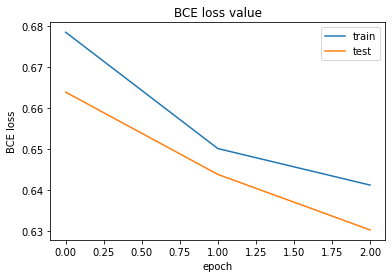

In [222]:
plt.plot(losses2)
plt.plot(losses_eval2)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [226]:
def predict_2(model, iterator):
    model.eval()
    fp = []
    fn = []
    tp = [] 
    tn = []
    with torch.no_grad():
        for i, (texts, words, ys) in enumerate(iterator):   
            preds = model(texts, words)  # делаем предсказания на тесте 
            for pred, gold, text, wordd in zip(preds, ys, texts, words):
                text = ' '.join([id2word[int(word)] for word in text if word !=0])+
                if round(pred.item()) > gold:
                    fp.append(text)
                elif round(pred.item()) < gold:
                    fn.append(text)
                elif round(pred.item()) == gold == 1:
                    tp.append(text)
                elif round(pred.item()) == gold == 0:
                    tn.append(text)
    return fp, fn, tp, tn

In [227]:
fp2, fn2, tp2, tn2 = predict_2(model_2, val_iterator2)

теперь можно и сравнить модели по метрикам:

In [235]:
def all_metrics(tp, tn, fp, fn):
    acc = (len(tp)+len(tn))/(len(tp2)+len(tn)+len(fp)+len(fn))
    recall = (len(tp))/(len(tp)+len(fp))
    prec = (len(tp))/(len(tp)+len(fp))
    return acc, recall, prec

In [237]:
print(f'accuracy of 1-headed model is:{all_metrics(tp,tn,fp,fn)[0]}')
print(f'accuracy of 2-headed model is:{all_metrics(tp2,tn2,fp2,fn2)[0]}')

accuracy of 1-headed model is:0.7341385775956046
accuracy of 2-headed model is:0.6415456168580687


In [238]:
print(f'recall of 1-headed model is:{all_metrics(tp,tn,fp,fn)[1]}')
print(f'recall of 2-headed model is:{all_metrics(tp2,tn2,fp2,fn2)[1]}')

recall of 1-headed model is:0.7420015357051446
recall of 2-headed model is:0.6168511049057124


In [239]:
print(f'precision of 1-headed model is:{all_metrics(tp,tn,fp,fn)[2]}')
print(f'precision of 2-headed model is:{all_metrics(tp2,tn2,fp2,fn2)[2]}')

precision of 1-headed model is:0.7420015357051446
precision of 2-headed model is:0.6168511049057124


по всем фронтам, как ни странно, первая лучше. Может, мы накосячили в архитектуре, а может, и правда модели лишние признаки только мешают...

In [228]:
print('что правильно предсказываем положительным:', tp2[:100])

что правильно предсказываем положительным: ['на збс если что тебя рубашка меня вкусняшка', 'особенно по ане по их интересным про мистера который жрал про какого-то', 'вас харькове тишина спокойствие все страсти только киеве да', 'посмотрела подряд серии моего любимого сериала ангел или демон не перестаю им восхищаться', 'это точно ты точно будешь учить но это не смешно тоже не выучу', 'семь тысяч дельфинов на вчера', 'да юн си юн милашка вот ещё держи няшку', 'скучно как-то спать завтра пятница думаю будет весело', 'делаю вид что понимаю немецкий', 'правда не классе команде но тоже самое для меня', 'на рынке можно те ребята как раз на', 'выздоравливай мы ждем тебя особенно преподаватели', 'все нормально тебя', 'найл фаак где туалет лиам ну скоро уже зейн нужно круто улыбнуться гарри изизи луи черт идиоты', 'ахахаа решила русский сделать', 'только мама нас держит всю жизнь животе до лет на руках всю жизнь своём сердце', 'когда становиться совсем скучно или совсем плохо можно', 'может бы

между прочим, не так плохо! "люблю", "доброй ночи" - в принципе, зерна истины есть

In [240]:
print('что правильно предсказываем отрицательным:', tn2[:100])

что правильно предсказываем отрицательным: ['нет нет нет опять мне на глаза попались вчерашние фотки со мной черные очки капюшон мне', 'эх всем поки спать ибо через часов мне вставать', 'чем', 'театр первые места сожалению не сильно ожидала большего', 'почему бы не не высыпаться мне на лицо мама смеялась', 'мне рублей на телефон пожалуйста', 'гуляю собакой идут школьника лет по ним идет они ему мы говно взорвали оно бля где мои лет', 'пробовала меня ничего не изменилось', 'хочу жить штатов не могу без нхл но без сна тоже плохо', 'таких проблем но он много занимает', 'как же ненавижу должен всю семью до слез довести разве так можно', 'не знаю как это делается ни разу не делали', 'действительно расстраиваюсь от того что меня не очень выходит играть волейбол', 'хочу сменить фон но интернет на ноуте не грузится', 'не берет', 'сдохла венда на десткопе музыки на ноуте нет теперь понимаю трушность ластфма но вот платить за него', 'плохо мне ручки болят ножки болят чтоооооо ещё такооое', 'блин

"слезы", "бля", "лох"...не поспоришь.

In [241]:
print('что ложно предсказываем положительным:', fp2[:100])

что ложно предсказываем положительным: ['зато уверен фсб заебись как корпоратив отпраздновали', 'там нет бургер кинга тортов шоколадок', 'да где птичка', 'вся маленькая бедненькая под родительского ты', 'точно только имя знаю все', 'спасибо но лучше было бы чтобы это были но это нереально', 'ахаха круто вам нас просто тупо ранняя весна', 'если тебя нет предновогоднего праздничного настроения', 'жалко так волосы', 'глаза боюсь закрыть от того что вижу его костюме гробу очень страшно', 'волшебных праздников тебе', 'скорее всего снега на год не будет', 'вам пишу чего же боле ведь вы на воле', 'всегда больно когда идти на преступление пробелы между', 'не успею тогда мне на работу выйти пойду тогда быстро щас сам', 'даже эта', 'пересматриваю на свою голову как же он ревнует пошел майкрофта звать срочно ну е-мое', 'мне надоело делать маркетинг все время марс', 'боже скоро новый год где кем праздновать без понятия', 'моя одноклассница группу ван ди вк ааааа теперь она спалит', 'забей они все 

а у нас явно проблемы с сарказмом! впрочем, это не так уж и удивительно - мы ведь нейросеть.

In [242]:
print('что ложно предсказываем отрицательным:', fn2[:100])

что ложно предсказываем отрицательным: ['сегодня', 'если бы ты закончила есть рис раньше меня не было бы этого шанса сделать мир чуть лучше', 'какой классный тебя метод надо так же попробовать песнями вызывают меня больные воспоминания', 'прочитал уже до страницы книгу она такая интересная жду часть', 'когда его только услышала то ничего не поняла продолжила слушать мама бит', 'вот как как можно больше друзей твиттер тут интересней чем вк плане того что можно держать руку на событий друзей', 'ойй меня субботу на первом не было не знаю аххаах позор но кто то что пятницу точно будет', 'хех не повезло но можно самому немецкий изучать он не такой сложный хд', 'вот красава тебе не сомневался', 'кто то добавил меня чс из моих друзей так хочеться узнать кто это', 'нет бы первый раз за двое суток нормально поесть так нет', 'меня бесят люди которые не матерятся если только это не нежные симпатичные тян так бесят штоле бля', 'как же достала эта школа хочу домой спать есть нормальную еду', 'госпо

ах, если бы ты закончила есть рис раньше...но, кажется, мы тоже остро реагируем на мат.